In [ ]:
import math
from pyspark.sql import SparkSession

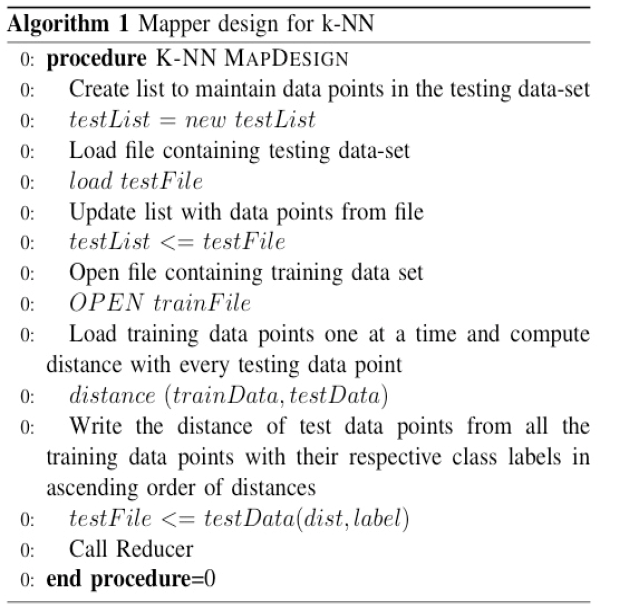

In [ ]:
from pyspark.sql import SparkSession
import math

# Create a SparkSession
spark = SparkSession.builder.appName("KNN").getOrCreate()

# Define Euclidean distance function
def euclidean_distance(row1, row2):
    dist = 0.0
    for i in range(len(row1) - 1):
        dist += (row1[i] - row2[i]) ** 2
    return math.sqrt(dist)

# Set the number of neighbors
k = 3

# Load the data
train_data = spark.read.csv('dataset/preprocessed_train.csv', header=True, inferSchema=True)
test_data = spark.read.csv('dataset/preprocessed_test.csv', header=True, inferSchema=True)

# Convert the data to RDD
train_rdd = train_data.rdd
test_rdd = test_data.rdd

# Broadcast train data
train_broadcast = spark.sparkContext.broadcast(train_rdd.collect())

# Implement mapper function to calculate distance of each row in test data to all rows in train data
def mapper(row):
    distances = []
    train_data = train_broadcast.value
    for train_row in train_data:
        dist = euclidean_distance(row, train_row)
        distances.append((dist, train_row[-1]))
    distances.sort(key=lambda x: x[0])
    return distances[:k]

# Calculate the distance of each row in test data to all rows in train data
results = test_rdd.map(lambda row: mapper(row))

# Implement reducer function to get the most common class
def reducer(row):
    classes = {}
    for i in range(k):
        if row[i][1] in classes:
            classes[row[i][1]] += 1
        else:
            classes[row[i][1]] = 1
    return max(classes, key=classes.get)

# Get the most common class for each row in test data
predictions = results.map(lambda row: reducer(row))

# Get the actual classes
actual = test_rdd.map(lambda row: row[-1])

# Get the most common class for each row in test data
predictions = results.map(lambda row: reducer(row))

# Get the actual classes
actual = test_rdd.map(lambda row: row[-1])

# Debugging: Check the first few elements of predictions and actual RDDs
print("Predictions sample:", predictions.take(5))
print("Actual sample:", actual.take(5))

# Debugging: Check the lengths of predictions and actual RDDs
print("Predictions count:", predictions.count())
print("Actual count:", actual.count())

# Check if predictions and actual RDDs are correctly zipped
zipped = predictions.zip(actual).take(5)
print("Zipped sample:", zipped)

# Calculate the accuracy
correct = predictions.zip(actual).filter(lambda x: x[0] == x[1]).count()
accuracy = correct / float(test_rdd.count())

print("Accuracy: ", accuracy)
